In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

C:\Users\Yan Zhang\AppData\Local\Temp\ipykernel_19112\2454360658.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Part 1 Exploratory Data Analysis

In [2]:
# read data
df = pd.read_json("../ultimate_challenge/logins.json")
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [4]:
df.describe()

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


In [5]:
df['login_time'] = pd.to_datetime(df['login_time'])
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [6]:
df1 = df.set_index('login_time')
df1['count'] = 1
df1 = df1.resample('15min').sum()
df1.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Text(0, 0.5, 'count of login')

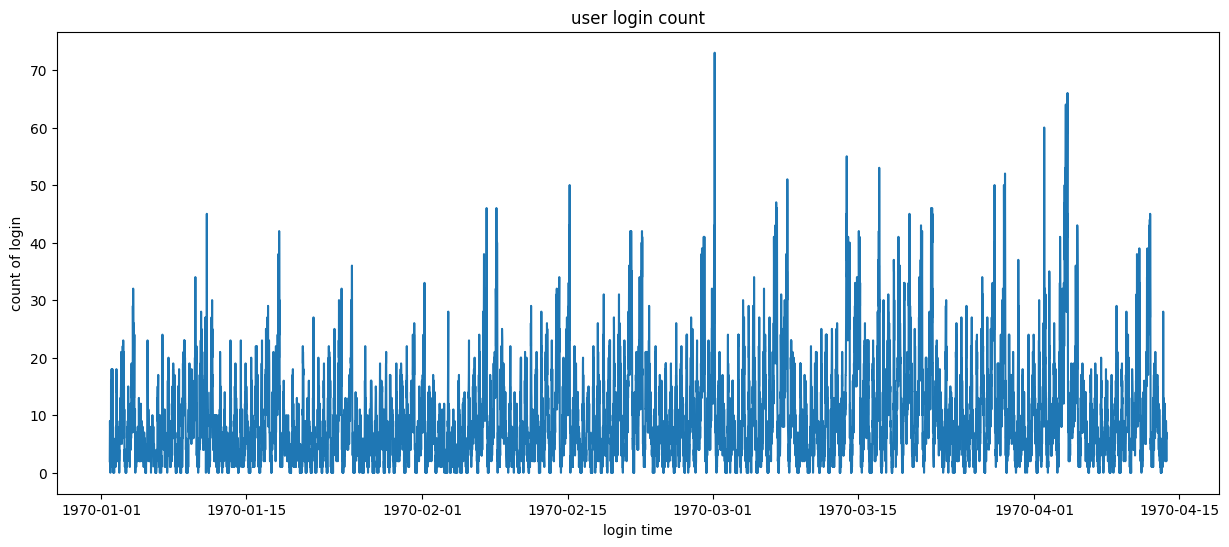

In [7]:
plt.figure(figsize = (15,6))
plt.plot(df1)
plt.title("user login count")
plt.xlabel("login time")
plt.ylabel("count of login")

there is weekly peak pattern. zoomed into weekly data to check, which contents about 700 data

Text(0, 0.5, 'count of login')

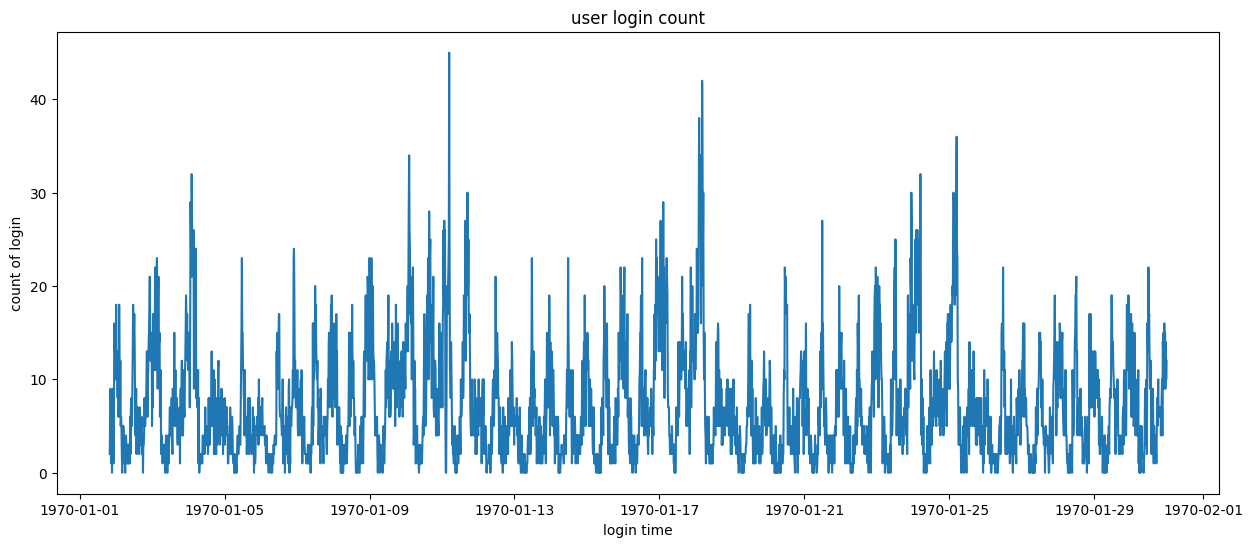

In [8]:
#one month data
plt.figure(figsize = (15,6))
plt.plot(df1[0:2800])
plt.title("user login count")
plt.xlabel("login time")
plt.ylabel("count of login")

it shows a weekly pattern.

In [9]:
df1['count'].max()

73

In [10]:
df1[df1['count']==73]

,count
login_time,
1970-03-01 04:30:00,73


the maximum login couunt is 73 which is correspond to march 01 1970, which is Sunday.

# Part 2 Experiment and Metrics Design

# Part 3 Predictive Model

## Data wrangling and EDA

In [11]:
rider = pd.read_json("../ultimate_challenge/ultimate_data_challenge.json")
rider.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [12]:
# check duplicates
rider.duplicated().value_counts()

False    49992
True         8
Name: count, dtype: int64

In [13]:
rider['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [14]:
rider['city']=rider['city'].replace("King's Landing", "Kings Landing")

In [33]:
rider['city'] = rider['city'].astype('str')
rider['phone'] = rider['phone'].astype('str')

There are 8 duplicates, now remove the duplicates

In [34]:
rider.drop_duplicates(inplace = True)

In [35]:
rider.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49596 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49596 non-null  object        
 1   trips_in_first_30_days  49596 non-null  int64         
 2   signup_date             49596 non-null  datetime64[ns]
 3   avg_rating_of_driver    49596 non-null  float64       
 4   avg_surge               49596 non-null  float64       
 5   last_trip_date          49596 non-null  datetime64[ns]
 6   phone                   49596 non-null  object        
 7   surge_pct               49596 non-null  float64       
 8   ultimate_black_user     49596 non-null  bool          
 9   weekday_pct             49596 non-null  float64       
 10  avg_dist                49596 non-null  float64       
 11  avg_rating_by_driver    49596 non-null  float64       
 12  active                  49596 non-null  int64      

There are missing values in 'avg_rating_of_driver' ,'phone','avg_rating_by_driver' 

In [17]:
# check missing values
rider.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8119
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [18]:
# fill phone using 'bfill')
# rider['phone'].fillna(method ='bfill')
rider = rider.drop(rider[rider['phone'].isna()==True].index,axis=0)
rider.info()
# fill the missing values with mean


<class 'pandas.core.frame.DataFrame'>
Index: 49596 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49596 non-null  object 
 1   trips_in_first_30_days  49596 non-null  int64  
 2   signup_date             49596 non-null  object 
 3   avg_rating_of_driver    41573 non-null  float64
 4   avg_surge               49596 non-null  float64
 5   last_trip_date          49596 non-null  object 
 6   phone                   49596 non-null  object 
 7   surge_pct               49596 non-null  float64
 8   ultimate_black_user     49596 non-null  bool   
 9   weekday_pct             49596 non-null  float64
 10  avg_dist                49596 non-null  float64
 11  avg_rating_by_driver    49398 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [19]:
rider['avg_rating_of_driver']= rider['avg_rating_of_driver'].fillna(rider['avg_rating_of_driver'].mean())
rider['avg_rating_by_driver']=rider['avg_rating_by_driver'].fillna(rider['avg_rating_by_driver'].mean())

In [20]:
rider.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49596 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49596 non-null  object 
 1   trips_in_first_30_days  49596 non-null  int64  
 2   signup_date             49596 non-null  object 
 3   avg_rating_of_driver    49596 non-null  float64
 4   avg_surge               49596 non-null  float64
 5   last_trip_date          49596 non-null  object 
 6   phone                   49596 non-null  object 
 7   surge_pct               49596 non-null  float64
 8   ultimate_black_user     49596 non-null  bool   
 9   weekday_pct             49596 non-null  float64
 10  avg_dist                49596 non-null  float64
 11  avg_rating_by_driver    49596 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


acitve users are the ones took a trip in the preceeding 30 days.

In [21]:
rider['last_trip_date'] = pd.to_datetime(rider['last_trip_date'] )
rider['signup_date']= pd.to_datetime(rider['signup_date'])
rider.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49596 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49596 non-null  object        
 1   trips_in_first_30_days  49596 non-null  int64         
 2   signup_date             49596 non-null  datetime64[ns]
 3   avg_rating_of_driver    49596 non-null  float64       
 4   avg_surge               49596 non-null  float64       
 5   last_trip_date          49596 non-null  datetime64[ns]
 6   phone                   49596 non-null  object        
 7   surge_pct               49596 non-null  float64       
 8   ultimate_black_user     49596 non-null  bool          
 9   weekday_pct             49596 non-null  float64       
 10  avg_dist                49596 non-null  float64       
 11  avg_rating_by_driver    49596 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1)

Because the document didn't indicated the current date, here use the latest last trip date as current date.

In [22]:
current_date = rider['last_trip_date'].max()
current_date

Timestamp('2014-07-01 00:00:00')

In [23]:
rider['active']=rider['last_trip_date'].apply(lambda date: 1 if (current_date- date).days <= 30 else 0)

In [24]:
rider['active'].value_counts(normalize = True)

active
0    0.623538
1    0.376462
Name: proportion, dtype: float64

0.376 or 37.6% are active users.

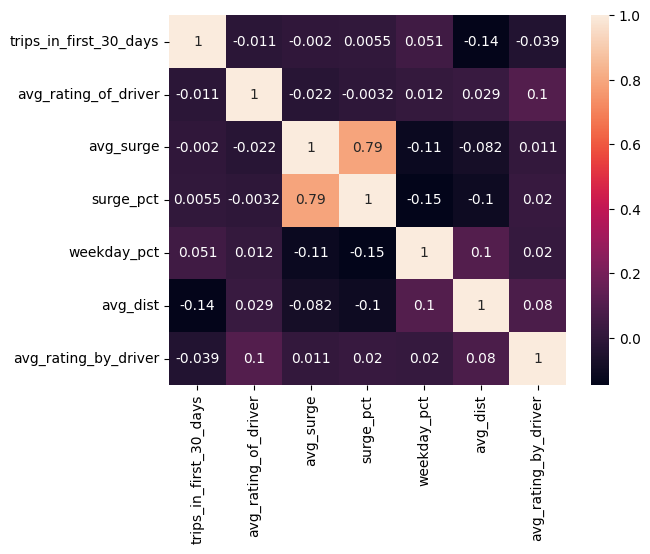

In [25]:
numeric_col=['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','weekday_pct','avg_dist','avg_rating_by_driver']
sns.heatmap(rider[numeric_col].corr(), annot = True)
plt.show()

there is no obvious linearity correlation (>0.90)among numerica features.

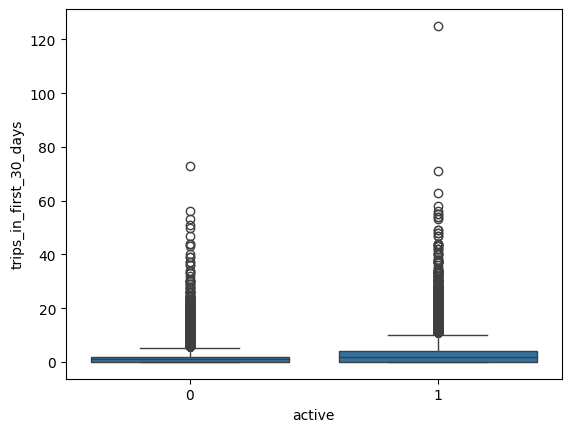

In [26]:
sns.boxplot(data=rider, x="active", y="trips_in_first_30_days")
plt.show()

In [27]:
 pd.pivot_table(rider, index=['active'],values=numeric_col,
                       aggfunc={'trips_in_first_30_days': ["median", "mean","std"],
                                 'avg_rating_of_driver': ["median", "mean","std"],
                               'avg_surge': ["median", "mean","std"],
                               'surge_pct': ["median", "mean","std"],
                               'weekday_pct': ["median", "mean","std"],
                               'avg_dist': ["median", "mean","std"],
                                'avg_rating_by_driver': ["median", "mean","std"]})

avg_dist                  avg_rating_by_driver                   \
            mean median       std                 mean median       std   
active                                                                    
0       6.191528   4.03  6.184459             4.786933    5.0  0.503901   
1       5.113930   3.73  4.617779             4.762739    4.8  0.328707   

       avg_rating_of_driver                  avg_surge  ...            \
                       mean median       std      mean  ...       std   
active                                                  ...             
0                  4.606040    4.8  0.591597  1.075708  ...  0.251999   
1                  4.593766    4.7  0.518625  1.073834  ...  0.162905   

       surge_pct                   trips_in_first_30_days                   \
            mean median        std                   mean median       std   
active                                                                       
0       8.702341    0.0  22.223566               1.657203    1.0  2.656090   
1       9.165615    0.0  15.599652               3.304804    2.0  4.985057   

       weekday_pct                    
              mean median        std  
active                                
0        60.611929   69.2  40.979907  
1        61.344208   64.3  29.512875  

[2 rows x 21 columns]

for active users, it shows lower median avg_dist, lower avg_rating_by_driver, and lower ave_rating_of_driver, but higher trips_in_first_30_days.

## Preprocessing

In [29]:
X = rider.loc[:, rider.columns!='active']
y = rider['active']

In [36]:
# transforms the features to follow a uniform or a normal distribution
trans = QuantileTransformer(random_state = 123)
features= trans.fit_transform(X)

ValueError: could not convert string to float: 'Kings Landing'